In [1]:
!pip install tensorflow-datasets

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Graphs

In [3]:
## Helper function to display metric graphs
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])



### Input Pipeline

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print(train_dataset.element_spec)

for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy()[: 3])
    print()
    print("labels: ", label.numpy()[: 3])

text:  [b'***SPOILERS*** ***SPOILERS*** Are all teen slasher flicks suffering from a drought of originality? It awfully seems so. First of all, this is a noble premise that could\'ve been utilized well. A rejected young nerd who grows up, stalks and murders all the girls who tortured the hell out of him when he was in junior high? Can\'t say you had nothing to work with. But this film goes through the same motions as all the other recent slashers. Everything from the score to the camera angles allow us to predict exactly when a false alarm is coming and exactly when the killer will strike. We know the pattern by now. These stupid slasher movies push the credibility envelope more and more by the minute. Let me ask you something: Who, in their right mind, is going to surprise a friend of theirs in a dark, dreary morgue in the middle of the night and just surprise her out of the blue while she\'s all alone and surrounded by corpses? Does that make any damn sense at all?<br /><br />"Valent

### Create the text encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[: 20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [25]:
for example_test, label in test_dataset.take(1):
    pass

In [26]:
encoded_test_dataset = encoder(example)[::].numpy()
encoded_test_dataset

array([[  1,   1,  24, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0],
       [ 10, 103,  10, ...,   0,   0,   0],
       ...,
       [230,   1, 838, ...,   0,   0,   0],
       [  8,   4, 169, ...,   0,   0,   0],
       [  5,  32,   2, ...,   0,   0,   0]], dtype=int64)

In [24]:
encoded_dataset = encoder(example)[: :].numpy()
encoded_dataset

array([[  1,   1,  24, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0],
       [ 10, 103,  10, ...,   0,   0,   0],
       ...,
       [230,   1, 838, ...,   0,   0,   0],
       [  8,   4, 169, ...,   0,   0,   0],
       [  5,  32,   2, ...,   0,   0,   0]], dtype=int64)

In [23]:
# train_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [22]:
# vt = encoder(train_dataset)

ValueError: Exception encountered when calling layer "text_vectorization" (type TextVectorization).

Attempt to convert a value (<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>) to a Tensor.

Call arguments received:
  • inputs=<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

### Model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        mask_zero = True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [13]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
TF_FORCE_GPU_ALLOW_GROWTH = 1

physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


RuntimeError: Physical devices cannot be modified after being initialized

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu.options.allow_growth = True
session = InteractiveSession(config=config) 

AttributeError: gpu

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

391/391 [==============================] - 18s 47ms/step - loss: 0.3289 - accuracy: 0.8629
Test Loss:  0.32888492941856384
Test Accuracy:  0.8629199862480164


(0.0, 0.6527052894234657)

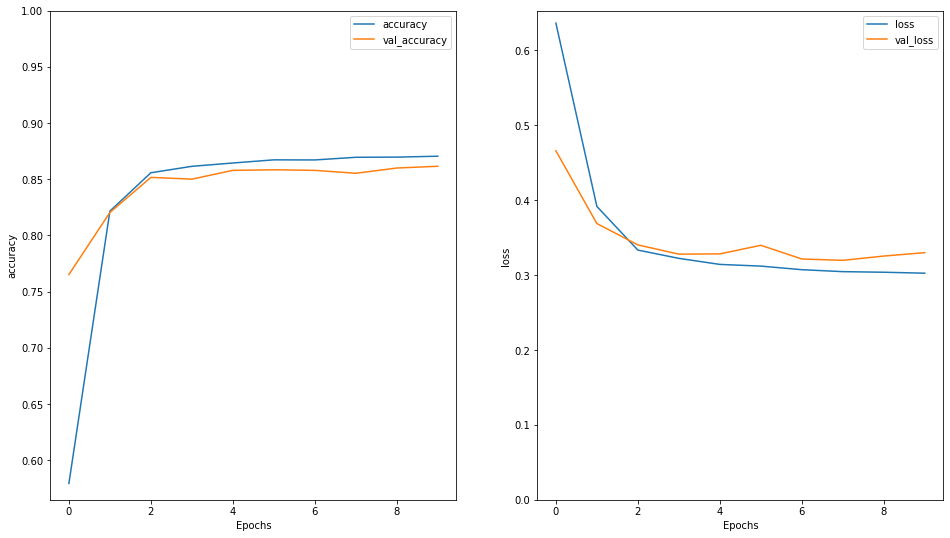

In [17]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")
plt.ylim(0, None)

### Prediction

In [18]:
sample_text = (r"Because of the laboriousness of the translation process, since the 1940s efforts have been made, with varying degrees of success, to automate translation or \
               to mechanically aid the human translator. More recently, the rise of the Internet has fostered a world-wide market for translation services and has facilitated \
                'language localization'. Ideally, the translator must know both languages, as well as the subject that is to be translated.")

predictions = model.predict(np.array([sample_text]))
predictions

array([[1.9441489]], dtype=float32)

In [19]:
sample_text2 = ("Movies was not inspiring, it shows and content were not upto the marks or not creativity in it. So donot watch this movie it's time waste.")

preds2 = model.predict(np.array([sample_text2]))
preds2

array([[-1.8685884]], dtype=float32)

In [20]:
if(predictions>0.0):
    print("Positive")
else:
    print("Negative")

Positive


In [21]:
model.save("model/")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [31]:
## Model Deployement

model_json = model.to_json()
with open('model.json', 'w') as js:
    js.write(model_json)
model.save_weights('model', save_format='tf')